In [396]:
pip install --upgrade scikit-learn==1.4.2

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [397]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score, roc_auc_score
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [398]:
# Load the dataset
file_path = 'BRCA.csv'  # Replace with your file path if needed
data = pd.read_csv(file_path)

In [399]:
# Drop Patient_ID
data_cleaned = data.drop(columns=['Patient_ID'])

# Convert dates to datetime format
data_cleaned['Date_of_Surgery'] = pd.to_datetime(data_cleaned['Date_of_Surgery'], format='%d-%b-%y')
data_cleaned['Date_of_Last_Visit'] = pd.to_datetime(data_cleaned['Date_of_Last_Visit'], format='%d-%b-%y')

In [400]:
# Create Follow_Up_Duration feature
data_cleaned['Follow_Up_Duration'] = (data_cleaned['Date_of_Last_Visit'] - data_cleaned['Date_of_Surgery']).dt.days

# Drop rows where Follow_Up_Duration is null
data_cleaned = data_cleaned.dropna(subset=['Follow_Up_Duration'])

# Drop the original date columns as they are no longer needed
data_cleaned = data_cleaned.drop(columns=['Date_of_Surgery', 'Date_of_Last_Visit'])


In [401]:
# Encode categorical variables
label_encoders = {}
for column in ['Gender', 'Tumour_Stage', 'Histology', 'ER status', 'PR status', 'HER2 status', 'Surgery_type', 'Patient_Status']:
    le = LabelEncoder()
    data_cleaned[column] = le.fit_transform(data_cleaned[column])
    label_encoders[column] = le

In [402]:
# Define features and target variable
X = data_cleaned.drop(columns=['Patient_Status'])
y = data_cleaned['Patient_Status']

In [403]:
# Ensure X and y have matching indices
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [404]:
# Check the data types to ensure no DateTime64 types are present
print("Data types in X after cleaning:", X.dtypes)

Data types in X after cleaning: Age                   float64
Gender                  int32
Protein1              float64
Protein2              float64
Protein3              float64
Protein4              float64
Tumour_Stage            int32
Histology               int32
ER status               int32
PR status               int32
HER2 status             int32
Surgery_type            int32
Follow_Up_Duration    float64
dtype: object


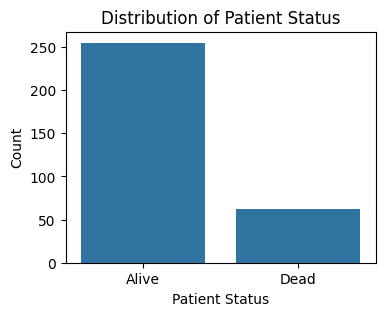

In [405]:
# Plot the distribution of Patient_Status
plt.figure(figsize=(4, 3))
sns.countplot(x='Patient_Status', data=data_cleaned)
plt.title('Distribution of Patient Status')
plt.xlabel('Patient Status')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Alive', 'Dead'])
plt.show()

In [406]:
# Simplified resampling strategy
# First apply SMOTE to oversample the minority class
oversample = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Then apply RandomUnderSampler to slightly undersample the majority class
undersample = RandomUnderSampler(sampling_strategy=0.80, random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X_resampled, y_resampled)


In [407]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

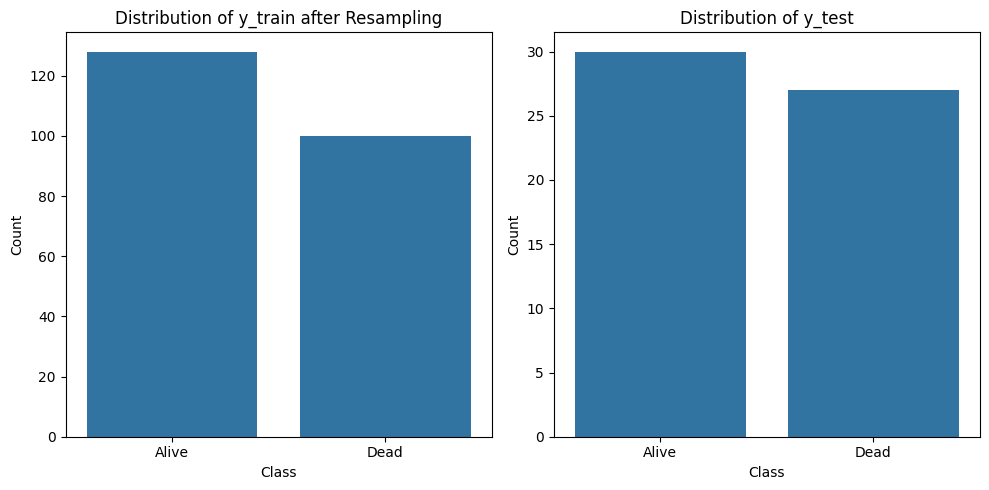

In [408]:
# Visualize the distribution of y_train and y_test
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Distribution of y_train after Resampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Alive', 'Dead'])

plt.subplot(1, 2, 2)
sns.countplot(x=y_test)
plt.title('Distribution of y_test')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Alive', 'Dead'])

plt.tight_layout()
plt.show()


In [409]:
# Set up the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 30, 40],
    'min_samples_split': [4, 8, 14],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [410]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

In [411]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

In [412]:
# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 30, 40],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [4, 8, 14],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy', verbose=2)

In [413]:
# Get the best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best parameters found by GridSearchCV: {best_params}")

Best parameters found by GridSearchCV: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}


In [414]:
# Train the best model using the best parameters
best_rf_model = grid_search.best_estimator_

In [415]:
# Evaluate the best model
y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])

print(f"Best Model Accuracy: {accuracy}")
print(f"Best Model Precision: {precision}")
print(f"Best Model F1 Score: {f1}")
print(f"Best Model ROC-AUC Score: {roc_auc}")

Best Model Accuracy: 0.6842105263157895
Best Model Precision: 0.68
Best Model F1 Score: 0.6538461538461539
Best Model ROC-AUC Score: 0.7493827160493827


In [416]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        30
           1       0.68      0.63      0.65        27

    accuracy                           0.68        57
   macro avg       0.68      0.68      0.68        57
weighted avg       0.68      0.68      0.68        57



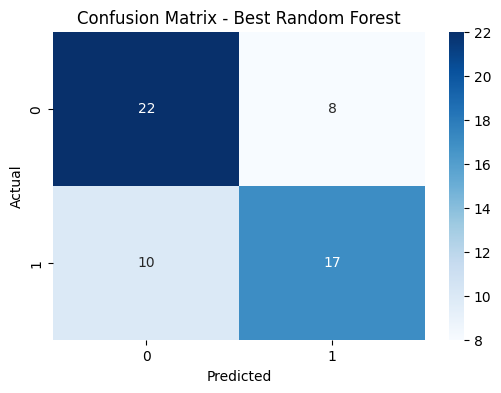

In [417]:
# Confusion matrix as a heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Best Random Forest")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

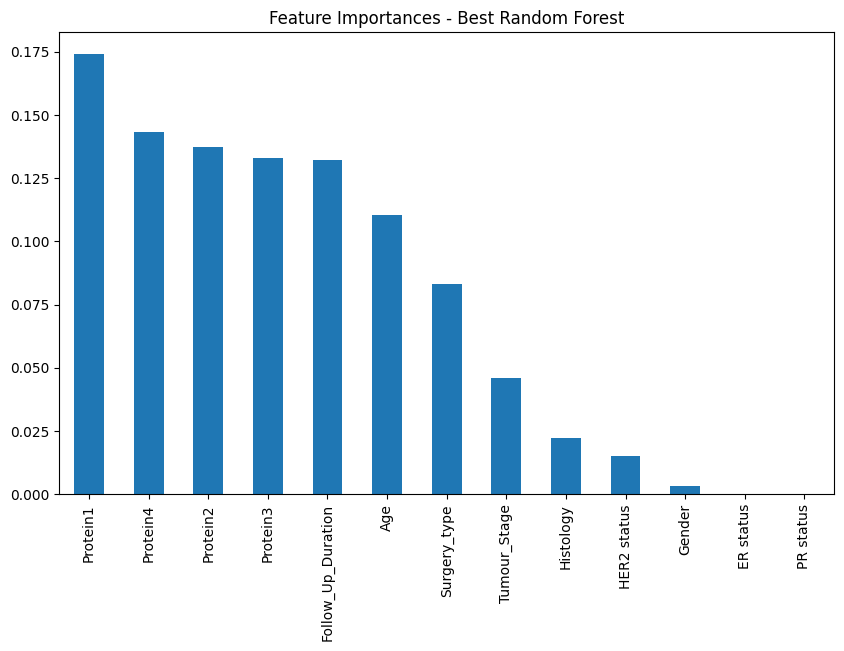

In [418]:
# Feature importance
feature_importances = pd.Series(best_rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importances - Best Random Forest')
plt.show()

In [419]:
# Save the best model and scaler
model_filename = 'best_random_forest_model.pkl'
scaler_filename = 'scaler.pkl'
joblib.dump(best_rf_model, model_filename)
joblib.dump(scaler, scaler_filename)
print(f"Best Model saved as {model_filename}")
print(f"Scaler saved as {scaler_filename}")

Best Model saved as best_random_forest_model.pkl
Scaler saved as scaler.pkl


In [420]:
import sklearn
print(sklearn.__version__)

1.4.2


In [421]:
import joblib
import numpy as np

In [422]:
# Load the model and scaler
model = joblib.load('best_random_forest_model.pkl')
scaler = joblib.load('scaler.pkl')

In [423]:
# Assume these are the correct feature values based on the order of features in X
test_input = np.array([[0, 55, 20.0, 35.0, 30.0, 40.0, 1, 0, 1, 0, 2, 365, 50.0]])

# Ensure that this array has 13 values (one for each feature)
print(f"Test input has: {test_input.shape[1]} features")  # Should print 13

# Apply the scaler
test_input_scaled = scaler.transform(test_input)

Test input has: 13 features


c:\Users\ade14\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [424]:
print(X.columns)

Index(['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3', 'Protein4',
       'Tumour_Stage', 'Histology', 'ER status', 'PR status', 'HER2 status',
       'Surgery_type', 'Follow_Up_Duration'],
      dtype='object')


In [425]:
print(X_resampled.columns)

Index(['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3', 'Protein4',
       'Tumour_Stage', 'Histology', 'ER status', 'PR status', 'HER2 status',
       'Surgery_type', 'Follow_Up_Duration'],
      dtype='object')


In [426]:
X_train.shape

(228, 13)

In [427]:
# Make a prediction
prediction = model.predict(test_input_scaled)
prediction_proba = model.predict_proba(test_input_scaled)[:, 1]

print(f"Prediction: {prediction}")
print(f"Prediction Probability: {prediction_proba}")

Prediction: [0]
Prediction Probability: [0.49229505]
